# **Python Final Project: Predicting Professional Tennis Games**

## Overall Question: Which player will win a tennis game?


## Step 1: Importing Libraries and Reading in the Dataset
---

In [ ]:
# Import Libraries that will be used throughout the code
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
from sklearn.exceptions import DataConversionWarning

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import streamlit as st
import pickle

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Read in all the Data(2000-2017), Original Link to Data: https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset/data
games = pd.DataFrame()
for year in range(2000, 2018):
  current_games = pd.read_csv(f'/content/drive/My Drive/Spring 2025/Data Bootcamp/Final Project/Data/atp_matches_{year}.csv')
  games = pd.concat([games, current_games])

## Step 2: Exploring the initial dataset
---

### Very basic looking at data

In [ ]:
games.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-717,Orlando,Clay,32,A,20000501.0,1.0,102179,NaN,NaN,...,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0
1,2000-717,Orlando,Clay,32,A,20000501.0,2.0,103602,NaN,Q,...,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0
2,2000-717,Orlando,Clay,32,A,20000501.0,3.0,103387,NaN,NaN,...,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0
3,2000-717,Orlando,Clay,32,A,20000501.0,4.0,101733,NaN,NaN,...,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0
4,2000-717,Orlando,Clay,32,A,20000501.0,5.0,101727,4.0,NaN,...,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0


In [ ]:
games.info()
# Check types of variables and see what data is missing

<class 'pandas.core.frame.DataFrame'>
Index: 53571 entries, 0 to ('2017-M-DC-2017-WG-M-SUI-USA-01', 'Davis Cup WG R1: SUI vs USA', 'Hard', 4, 'D', 20170203, 5, 105449, nan, nan, 'Steve Johnson', 'R', 188.0, 'USA', 27.1019849418, 31.0, 1345.0, 134472, nan, nan)
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          53508 non-null  object 
 1   tourney_name        53494 non-null  object 
 2   surface             52250 non-null  object 
 3   draw_size           53508 non-null  object 
 4   tourney_level       53500 non-null  object 
 5   tourney_date        53440 non-null  float64
 6   match_num           53440 non-null  float64
 7   winner_id           53508 non-null  object 
 8   winner_seed         24126 non-null  float64
 9   winner_entry        9221 non-null   object 
 10  winner_name         53472 non-null  object 
 11  winner_hand         53458 non-null  object 
 12  winner_ht      

### Cleaning the Dataset

In [ ]:
# Cutting down the dataset to only the portion where the statistics are available. We drop the portion where the winner's ace statistic is missing
games = games.dropna(subset=['w_ace'])

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44451 entries, 0 to 2629
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          44451 non-null  object 
 1   tourney_name        44451 non-null  object 
 2   surface             44451 non-null  object 
 3   draw_size           44451 non-null  object 
 4   tourney_level       44451 non-null  object 
 5   tourney_date        44451 non-null  float64
 6   match_num           44451 non-null  float64
 7   winner_id           44451 non-null  object 
 8   winner_seed         20505 non-null  float64
 9   winner_entry        5837 non-null   object 
 10  winner_name         44451 non-null  object 
 11  winner_hand         44451 non-null  object 
 12  winner_ht           43611 non-null  float64
 13  winner_ioc          44451 non-null  object 
 14  winner_age          44451 non-null  float64
 15  winner_rank         43849 non-null  float64
 16  winner_ran

In [ ]:
# Fill all entries that are not Q or WC with DA (Direct Acceptance based on rank)
games.loc[:, 'winner_entry'] = games['winner_entry'].astype('object').fillna('DA')
games['loser_entry'] = games['loser_entry'].astype('object').fillna('DA')

# Any players without a seed are assumed to have been not seeded
games['winner_seed'] = games['winner_seed'].astype('object').fillna('Not Seeded')
games['loser_seed'] = games['loser_seed'].astype('object').fillna('Not Seeded')

# Impute minutes with the mean
games['minutes'] = games['minutes'].fillna(games['minutes'].mean())

# Assumes players without rank points just had 0 rank points when playing
games['winner_rank_points'] = games['winner_rank_points'].fillna(0)
games['loser_rank_points'] = games['loser_rank_points'].fillna(0)

# Replace players with missing ranks with Not Ranked (If they have 0 rank points, makes sense)
games['winner_rank'] = games['winner_rank'].astype('object').fillna('Not Ranked')
games['loser_rank'] = games['loser_rank'].astype('object').fillna('Not Ranked')

# Impute missing height with the mean
games['winner_ht'] = games['winner_ht'].fillna(games['winner_ht'].mean())
games['loser_ht'] = games['loser_ht'].fillna(games['loser_ht'].mean())

# One missing age value, replaced with mean age
games['loser_age'] = games['loser_age'].fillna(games['loser_age'].mean())

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44451 entries, 0 to 2629
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          44451 non-null  object 
 1   tourney_name        44451 non-null  object 
 2   surface             44451 non-null  object 
 3   draw_size           44451 non-null  object 
 4   tourney_level       44451 non-null  object 
 5   tourney_date        44451 non-null  float64
 6   match_num           44451 non-null  float64
 7   winner_id           44451 non-null  object 
 8   winner_seed         44451 non-null  object 
 9   winner_entry        44451 non-null  object 
 10  winner_name         44451 non-null  object 
 11  winner_hand         44451 non-null  object 
 12  winner_ht           44451 non-null  float64
 13  winner_ioc          44451 non-null  object 
 14  winner_age          44451 non-null  float64
 15  winner_rank         44451 non-null  object 
 16  winner_ran

In [ ]:
# Identify the winner and loser columns
winner_cols = ['winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand',
               'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points']

loser_cols = ['loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
              'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points']

# Identify the player stats columns
winner_stats = [col for col in games.columns if col.startswith('w_')]
loser_stats = [col for col in games.columns if col.startswith('l_')]

# Extract the columns that have to do with the players
player_1 = games[winner_cols + winner_stats].copy()
player_2 = games[loser_cols + loser_stats].copy()

# For these columns, then rename with player 1 and player 2 to remove the winner/loser label
player_1.columns = ['player_1_' + col.replace('winner_', '').replace('w_', '') for col in player_1.columns]
player_2.columns = ['player_2_' + col.replace('loser_', '').replace('l_', '') for col in player_2.columns]

# Identify the shared columns (non-player columns) in the dataset
shared_cols = ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
               'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes']
shared = games[shared_cols].copy()

# Combine all the parts after renaming into the new database
games = pd.concat([shared, player_1, player_2], axis=1)

# Randomly swap 50% of player_1 and player_2
swap_mask = np.random.rand(len(games)) < 0.5

p1_cols = [col for col in games.columns if col.startswith('player_1_')]
p2_cols = [col for col in games.columns if col.startswith('player_2_')]

# Perform swap on those rows
games.loc[swap_mask, p1_cols + p2_cols] = games.loc[swap_mask, p2_cols + p1_cols].values

# Create target variable, with 1 if the 1st player is the one that won, and 0
games['target'] = 1
games.loc[swap_mask, 'target'] = 0

In [ ]:
# Map the tourney_level to more understandable terms, currently just one letter each
tourney_level_mapping = {'A': 'ATP/ITF', 'C': 'Challenger', 'F': 'Futures', 'G': 'Grand Slam', 'M': 'Masters 1000'}

# Apply the mapping to the tourney_level column
games['tourney_level'] = games['tourney_level'].map(tourney_level_mapping)

In [ ]:
# To check if the data has really been swapped properly, comparing to the original
# games.to_csv('processed_games.csv', index=False)

### Some other column creation

In [ ]:
# Function to convert seeds and compute difference
def seeding_diff(seed1, seed2):
  s1 = 36 if seed1 == 'Not Seeded' else int(seed1)
  s2 = 36 if seed2 == 'Not Seeded' else int(seed2)
  return s1 - s2

# Using lambda to apply the function to every row in the dataset
games['seeding_difference'] = games.apply(lambda row: seeding_diff(row['player_1_seed'], row['player_2_seed']), axis = 1)
games

In [ ]:
# Separate out the two players and rename the columns
p1 = games[['tourney_date', 'player_1_name', 'target']].rename(columns={'player_1_name': 'player','target': 'won'})
p2 = games[['tourney_date', 'player_2_name', 'target']].rename(columns={'player_2_name': 'player','target': 'won'})

# player_2 wins if target == 0
p2['won'] = 1 - p2['won']

# Combine and sort by the tournament date, essentially in chronological order
combined = pd.concat([p1, p2], ignore_index=True)
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Figure out the win streak at each point in time
combined['prev_win'] = combined.groupby('player')['won'].shift(1).fillna(0)
combined['streak_id'] = (combined['prev_win'] != 1).groupby(combined['player']).cumsum()
combined['win_streak'] = combined.groupby(['player', 'streak_id']).cumcount()

# Group by win streak and calculate win rate
streak_winrate = combined.groupby('win_streak')['won'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=streak_winrate, x='win_streak', y='won', marker='o')
plt.title('Win Rate vs. Prior Win Streak')
plt.xlabel('Games Won in a Row Before Match')
plt.ylabel('Win Rate in Current Match')


# Combine both player dataframes into one combined data frame
combined = pd.concat([p1, p2], ignore_index=True)
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Group based on player the tournament date, essentially the tracker of each tournament
combined['tourney_id'] = combined.groupby('player')['tourney_date'].transform('first')

# Create a streak id that will reset for each player at the start of every new tournament, based on the separate tournament
combined['streak_reset'] = (combined['tourney_id'] != combined['tourney_id'].shift(1)).astype(int)

# Initialize the streak counter and count the number of wins during each tournament
combined['win_streak'] = 0
combined['win_streak'] = combined.groupby(['player', 'streak_reset']).cumcount()

# Sort combined by player and date, maintaining chronological sequence
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Compute win streaks
def compute_streak(won_series):
  return won_series.groupby((won_series != 1).cumsum()).cumcount() + 1

combined['win_streak'] = combined['won']
combined['win_streak'] = combined.groupby('player')['win_streak'].transform(compute_streak)

# Reset the win streak whenever the won flag is 0, essentially did not win at that tournament
combined.loc[combined['won'] != 1, 'win_streak'] = 0

# Ensure unique pairs for merge
player_streaks = (combined[['player', 'tourney_date', 'win_streak']].drop_duplicates(subset=['player', 'tourney_date'], keep='first'))

# Merge onto games
games = games.merge(player_streaks.rename(columns={'player': 'player_1_name', 'win_streak': 'player_1_win_streak'}), on=['player_1_name', 'tourney_date'],how='left')
games = games.merge(player_streaks.rename(columns={'player': 'player_2_name', 'win_streak': 'player_2_win_streak'}), on=['player_2_name', 'tourney_date'], how='left')

# Compute Difference
games['streak_diff'] = games['player_1_win_streak'] - games['player_2_win_streak']

# Plot winrate by streak difference
streak_winrate = games.groupby('streak_diff')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=streak_winrate, x='streak_diff', y='target', marker='o')
plt.title("Player 1 Win Rate by Win Streak Difference")
plt.xlabel("Win Streak Difference (Player 1 - Player 2)")
plt.ylabel("Probability Player 1 Wins")

## Step 5(In between Steps in the EDA File): Making the Regression Model to determine who wins

In [ ]:
# Select all the features that probably matter at least in the smallest extent, using as much data as possible that's not just full noise like the id, date, or answers like score and target
X = games.drop(['target', 'score', 'tourney_date', 'player_1_id', 'player_2_id'], axis = 1)
y = games['target']

# Fixing columns that have multiple data types, both floats and strings, like Rank with Not Ranked
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X[categorical_columns] = X[categorical_columns].astype(str)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

In [ ]:
# encode the categorical features with a one hot encoder that handles unknowns and also drops first to avoid multicollinearity, users a standard scaler for the numerial features
encoder = make_column_transformer((make_pipeline(OneHotEncoder(handle_unknown='ignore', drop = 'first')), selector(dtype_include='object')),
  (StandardScaler(), selector(dtype_include='number')))

### Logistic Regression

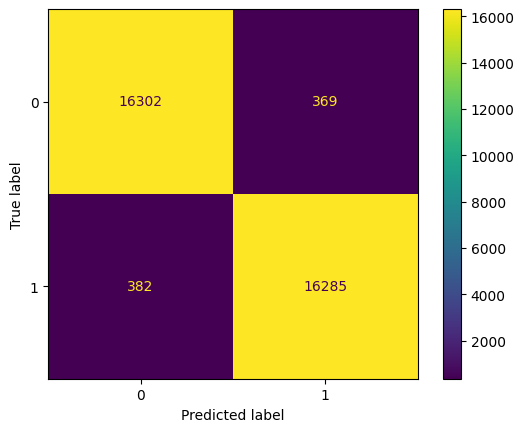

In [ ]:
# Create a pipe and confusion matrix for the logistic regression
lgr_pipe = Pipeline([('transforms', encoder), ('model', LogisticRegression())])
lgr_pipe.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_train, y_train);

In [ ]:
# Score the model
lgr_pipe.score(X_train, y_train)

0.9774731537584738

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
lgr_pipe.score(X_test, y_test)

0.9640061189597768

### KNN Classifier

In [ ]:
# Reset the index for X_train and y_train to have a more consistent chronological index
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

# Creates a sample of 5000 points from the training data to reduce the size and reduce the training time
X_sample = X_train.sample(5000, random_state = 30)
y_sample = y_train.loc[X_sample.index]

# Run a grid search over parameters at increments of 100 from 1 to 1000 and create a pipeline with optimal nneighbors
params = {'model__n_neighbors': np.arange(1, 1000, 100)}
knn_pipe = Pipeline([('transforms', encoder), ('model', KNeighborsClassifier(n_neighbors = 5))])
knn_grid = GridSearchCV(knn_pipe, param_grid = params)

# Fit the grid
knn_grid.fit(X_sample, y_sample)

GridSearchCV(estimator=Pipeline(steps=[('transforms',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4484e37d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44843c190>)])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': array([  1, 101, 201, 301, 401, 501, 601, 701, 801, 901])})

In [ ]:
# Figure out the best params
knn_grid.best_params_

{'model__n_neighbors': np.int64(101)}

In [ ]:
knn_grid.score(X_sample, y_sample)

0.898

In [ ]:
knn_grid.score(X_train, y_train)

0.8884756134141221

In [ ]:
knn_grid.score(X_test, y_test)

0.8894987852065149

### Decision Tree Classifier

In [ ]:
# Reset the index for X_train and y_train to have a more consistent chronological index
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

# Creates a sample of 5000 points from the training data to reduce the size and reduce the training time
X_sample = X_train.sample(5000, random_state = 30)
y_sample = y_train.loc[X_sample.index]

params = {'model__max_depth': np.arange(1, 21, 2)}
# Create a tree pipe
tree_pipe = Pipeline([('transform', encoder), ('model', DecisionTreeClassifier())])

# Create a grid search with the params on the tree pipe
tree_grid = GridSearchCV(tree_pipe, param_grid = params)

# Fit
tree_grid.fit(X_sample, y_sample)

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4484e37d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd44843c190>)])),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])})

In [ ]:
tree_grid.best_params_

{'model__max_depth': np.int64(9)}

In [ ]:
tree_grid.score(X_sample, y_sample)

0.9632

In [ ]:
tree_grid.score(X_train, y_train)

0.9176015357849902

In [ ]:
tree_grid.score(X_test, y_test)

0.9089354809682354

### Random Forest Classifier

In [ ]:
# Reset the index for X_train and y_train to have a more consistent chronological index
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

# Creates a sample of 5000 points from the training data to reduce the size and reduce the training time
X_sample = X_train.sample(5000, random_state = 30)
y_sample = y_train.loc[X_sample.index]

# Identify params to grid search throguh and initialize a random forest classifer
params = {'model__n_estimators': np.arange(1, 300, 100)}
rf_pipe = Pipeline([('transforms', encoder), ('model', RandomForestClassifier(random_state=42))])

# Grid search and fit
rf_grid = GridSearchCV(rf_pipe, param_grid = params)
rf_grid.fit(X_sample, y_sample)

GridSearchCV(estimator=Pipeline(steps=[('transforms',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd449ad2d90>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4432d8410>)])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__n_estimators': array([  1, 101, 201])})

In [ ]:
rf_grid.best_params_

{'model__n_estimators': np.int64(201)}

In [ ]:
rf_grid.score(X_sample, y_sample)

1.0

In [ ]:
rf_grid.score(X_train, y_train)

0.9448377227188194

In [ ]:
rf_grid.score(X_test, y_test)

0.9326914424547826

### Neural Network

In [ ]:
# Identify specifically the numerical columns to use for the neural network
numerical_columns = X.select_dtypes(include=[np.number]).columns
Xt_numerical = X[numerical_columns]

# Scale all of the numerical variables so that the size of the data doesn't specifically contribute to their importance
scaler = StandardScaler()
Xt_numerical = scaler.fit_transform(Xt_numerical)

# Split the data
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(Xt_numerical, y, test_size=0.2, random_state=30)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn.values, dtype=torch.float32)

In [ ]:
# Create a model with 2 hidden layers, with 64 nodes and 128 nodes respectively
model = nn.Sequential(nn.Linear(in_features = 31, out_features = 64), nn.ReLU(),  nn.Linear(in_features = 64, out_features = 128),
                      nn.ReLU(), nn.Linear(in_features = 128, out_features = 1))

# Use a binary loss function to score the classifier
loss_function = nn.BCEWithLogitsLoss()

# Create the optimization with Adam to reduce training time required
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
losses = []

for epoch in range(400):
  # make predictions
  yhat = model(X_train_tensor)
  # evaluate predictions
  loss = loss_function(yhat, y_train_tensor.unsqueeze(1))
  optimizer.zero_grad()

  loss.backward()
  # Computes the gradient
  optimizer.step()
  # .step goes in the direction of less loss (heavy lifting for optomization)

  # Print out as the model trains
  if epoch % 100 == 0:
    print(f'Epoch {epoch} Loss {loss}')
  losses.append(loss.item())

Epoch 0 Loss 0.6992694735527039
Epoch 100 Loss 0.04157117381691933
Epoch 200 Loss 0.03382452204823494
Epoch 300 Loss 0.020870167762041092


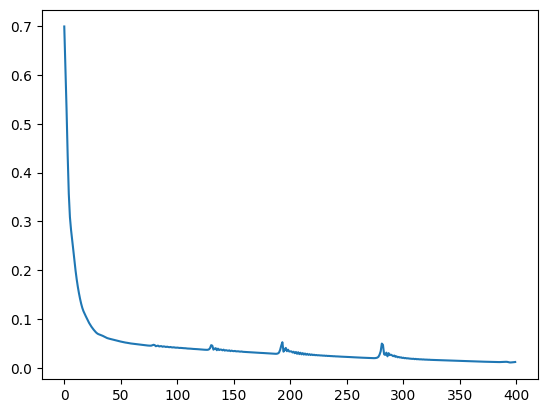

In [ ]:
plt.plot(losses)

In [ ]:
loss_function(yhat, y_train_tensor.unsqueeze(1))

tensor(0.0121, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation for inference
with torch.no_grad():
  # Make predictions
  y_pred = model(X_test_tensor)

  # Compute loss
  test_loss = loss_function(y_pred, y_test_tensor.unsqueeze(1)).item()

  # Convert logits to binary predictions
  y_pred_labels = (torch.sigmoid(y_pred) > 0.5).float()

  # Compute accuracy
  correct = (y_pred_labels.squeeze() == y_test_tensor).sum().item()
  total = y_test_tensor.size(0)
  test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1054, Test Accuracy: 0.9775


## Step 6: Predicting the number of sets needed


From the previous step, we see that the best 3 models to predict the tennis professional data with seem to be the logistic regression, random forest classification, and the neural network, so we will proceed with those 3 for further analysis

In [ ]:
def count_sets(score_str):
  # Split and Count the parts
  return len(score_str.split())

games['num_sets_played'] = games['score'].apply(count_sets)

In [ ]:
games.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_bpSaved,player_2_bpFaced,target,seeding_difference,points_bin,rank_group,player_1_win_streak,player_2_win_streak,streak_diff,num_sets_played
0,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,1.0,3-6 7-6(6) 7-6(4),3.0,R32,...,4.0,4.0,1,35,0-999,200-399,2,0,2,3
1,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,2.0,6-2 7-5,3.0,R32,...,4.0,6.0,0,0,0-999,200-399,0,2,-2,2
2,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,3.0,6-1 6-3,3.0,R32,...,0.0,0.0,0,0,0-999,200-399,0,2,-2,2
3,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,4.0,4-6 6-2 7-5,3.0,R32,...,9.0,12.0,0,-28,0-999,400-599,0,2,-2,3
4,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,5.0,6-1 6-4,3.0,R32,...,3.0,6.0,1,-32,0-999,400-599,4,0,4,2


In [ ]:
# Select all the features that probably matter at least in the smallest extent, using as much data as possible that's not just full noise like the id, date, or answers like score and target
X = games.drop(['target', 'score', 'tourney_date', 'player_1_id', 'player_2_id', 'num_sets_played'], axis = 1)
y = games['num_sets_played']

# Fixing columns that have multiple data types, both floats and strings, like Rank with Not Ranked
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X[categorical_columns] = X[categorical_columns].astype(str)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

# Create an encoder with OneHotEncoding for categorical, StandardScaling for numerical
encoder = make_column_transformer((make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first')), selector(dtype_include='object')),
    (StandardScaler(), selector(dtype_include='number')))

### Logistic Regression

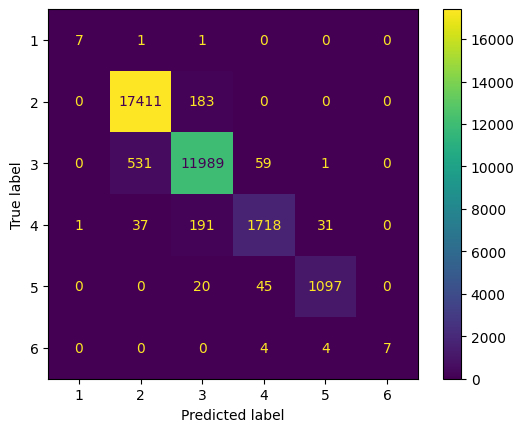

In [ ]:
# Create and run logistic regression, create ConfusionMatrix
lgr_pipe = Pipeline([('transforms', encoder), ('model', LogisticRegression())])
lgr_pipe.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_train, y_train);

In [ ]:
lgr_pipe.score(X_train, y_train)

0.9667346571479993

In [ ]:
lgr_pipe.score(X_test, y_test)

0.9347610906145956

In [ ]:
y_proba = lgr_pipe.predict_proba(X_test)[:, 1]
mean_squared_error(y_test, y_proba)

5.686837819623198

### Random Forest Classifier

In [ ]:
# Create the random sample of 5000 datapoints from the training data to use
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

X_sample = X_train.sample(5000, random_state = 30)
y_sample = y_train.loc[X_sample.index]

# Grid search through some estimator params and create the pipe
params = {'model__n_estimators': np.arange(1, 300, 100)}

rf_pipe = Pipeline([('transforms', encoder), ('model', RandomForestClassifier(random_state=42))])

rf_grid = GridSearchCV(rf_pipe, param_grid = params)

# Fit the grid random forest model
rf_grid.fit(X_sample, y_sample)

GridSearchCV(estimator=Pipeline(steps=[('transforms',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd449acc5d0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4499dbc90>)])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__n_estimators': array([  1, 101, 201])})

In [ ]:
rf_grid.best_params_

{'model__n_estimators': np.int64(201)}

In [ ]:
rf_grid.score(X_sample, y_sample)

1.0

In [ ]:
rf_grid.score(X_train, y_train)

0.9448377227188194

In [ ]:
rf_grid.score(X_test, y_test)

0.9326914424547826

In [ ]:
# Score the model with mean squared error
y_proba = rf_grid.predict_proba(X_test)[:, 1]
mean_squared_error(y_test, y_proba)

5.444073219960715

### Neural Network

In [ ]:
# Identify specifically the numerical columns to be used in the neural network
numerical_columns = X.select_dtypes(include=[np.number]).columns
Xt_numerical = X[numerical_columns]

# Scale using the standard scaler
scaler = StandardScaler()
Xt_numerical = scaler.fit_transform(Xt_numerical)

# Split the data
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(Xt_numerical, y, test_size=0.2, random_state=30)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn.values, dtype=torch.float32)

In [ ]:
# Create the model with 2 hidden layers
model = nn.Sequential(nn.Linear(in_features = 31, out_features = 64), nn.ReLU(),  nn.Linear(in_features = 64, out_features = 128),
                      nn.ReLU(), nn.Linear(in_features = 128, out_features = 1))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
losses = []

for epoch in range(400):
  #make predictions
  yhat = model(X_train_tensor)
  #evaluate predictions
  loss = loss_function(yhat, y_train_tensor.unsqueeze(1))
  optimizer.zero_grad()
  #This helps make sure that the gradients don't accumulate, we only want the gradients for that iteration

  loss.backward()
  # Computes the gradient
  optimizer.step()
  # .step goes in the direction of less loss (heavy lifting for optomization)

  if epoch % 100 == 0:
    print(f'Epoch {epoch} Loss {loss}')
  losses.append(loss.item())

Epoch 0 Loss 7.393764972686768
Epoch 100 Loss 0.08350951969623566
Epoch 200 Loss 0.06105748936533928
Epoch 300 Loss 0.048024505376815796


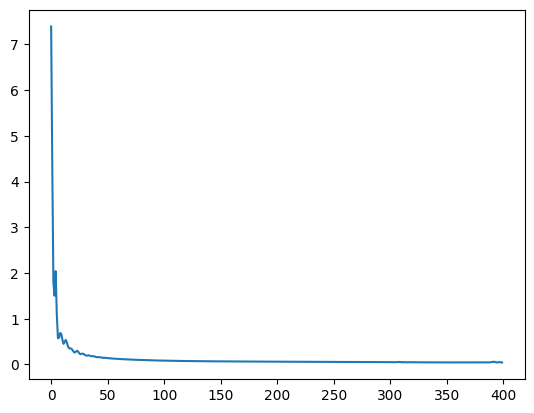

In [ ]:
plt.plot(losses)

In [ ]:
loss_function(yhat, y_train_tensor.unsqueeze(1))

tensor(0.0437, grad_fn=<MseLossBackward0>)

## Step 7: Combining it into Streamlit

To make this actually visible, this means that I have to limit the number of features, because users would only want to enter a certain number of datapoints. So, I will include only the most important features as identified through EDA. Particularly, these are break points faced, the win streak of both players at the time of playing, the round of the tournament, the surface they are playing on, the seed in the tournament both players are, and also the number of ranking points both players have. Best of how many games also should be included given that we are predicting how many games it would take a player to win. For the winrate, it seems like the best model to use is simple logistic regression and for the number of sets, the best model seems to be a neural net

In [ ]:
# Make x based on the description above, essentially features that matter a lot and should be used even with less features possible
X = games[['round', 'surface', 'best_of', 'player_1_seed', 'player_2_seed', 'player_1_rank_points', 'player_2_rank_points',
    'player_1_win_streak', 'player_2_win_streak', 'player_1_bpFaced', 'player_2_bpFaced', 'seeding_difference', 'streak_diff']]
y_sets = games['num_sets_played']
y_win = games['target']

# Fixing columns that have multiple data types, both floats and strings, like Rank with Not Ranked
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X.loc[:, categorical_columns] = X[categorical_columns].astype(str)

# Create two splits, one for the sets and one for training the win identification
X_train_sets, X_test_sets, y_train_sets, y_test_sets = train_test_split(X, y_sets, random_state = 30)
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(X, y_win, random_state = 30)

# Create the encoder
encoder = make_column_transformer((make_pipeline(OneHotEncoder(handle_unknown='ignore', drop='first')), selector(dtype_include='object')),
    (StandardScaler(), selector(dtype_include='number')))

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44451 entries, 0 to 44450
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   round                 44451 non-null  object 
 1   surface               44451 non-null  object 
 2   best_of               44451 non-null  float64
 3   player_1_seed         44451 non-null  object 
 4   player_2_seed         44451 non-null  object 
 5   player_1_rank_points  44451 non-null  int64  
 6   player_2_rank_points  44451 non-null  float64
 7   player_1_win_streak   44451 non-null  int64  
 8   player_2_win_streak   44451 non-null  int64  
 9   player_1_bpFaced      44451 non-null  float64
 10  player_2_bpFaced      44451 non-null  float64
 11  seeding_difference    44451 non-null  int64  
 12  streak_diff           44451 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 4.4+ MB


In [ ]:
# Train a logistic regression for the win identification
lgr_pipe = Pipeline([('transforms', encoder), ('model', LogisticRegression())])
lgr_pipe.fit(X_train_win, y_train_win)
lgr_pipe.score(X_test_win, y_test_win)

0.899037163682174

In [ ]:
# Train a neural network for the sets identification
# Identify the numerical data specifically
numerical_columns = X.select_dtypes(include=[np.number]).columns
Xt_numerical = X[numerical_columns]

# Scale the numerical data
scaler = StandardScaler()
Xt_numerical = scaler.fit_transform(Xt_numerical)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(Xt_numerical, y, test_size=0.2, random_state=30)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn.values, dtype=torch.float32)

# make the Neural net model with 2 hidden layers
model = nn.Sequential(nn.Linear(in_features = 9, out_features = 64), nn.ReLU(),  nn.Linear(in_features = 64, out_features = 128),
                      nn.ReLU(), nn.Linear(in_features = 128, out_features = 1))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

for epoch in range(400):
  #make predictions
  yhat = model(X_train_tensor)
  #evaluate predictions
  loss = loss_function(yhat, y_train_tensor.unsqueeze(1))
  optimizer.zero_grad()
  #This helps make sure that the gradients don't accumulate, we only want the gradients for that iteration

  loss.backward()
  # Computes the gradient
  optimizer.step()
  # .step goes in the direction of less loss (heavy lifting for optomization)

  if epoch % 100 == 0:
    print(f'Epoch {epoch} Loss {loss}')
  losses.append(loss.item())



Epoch 0 Loss 7.294809818267822
Epoch 100 Loss 0.22625680267810822
Epoch 200 Loss 0.22296486794948578
Epoch 300 Loss 0.22169636189937592


In [ ]:
# Save the scaler (used for the neural net)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)

# Save the LogisticRegression pipeline
with open('logistic_pipeline.pkl', 'wb') as f:
    pickle.dump(lgr_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)

torch.save(model.state_dict(), 'nn_model_state.pt')

In [ ]:
# Streamlit file (ran it on visual studio code for it to actually work, a screenshot is on the writeup)
# Logistic regression pipeline for predicting winner
with open('logistic_pipeline.pkl', 'rb') as f:
lgr_pipe_win = pickle.load(f)

# Scaler for neural network input
with open('scaler.pkl', 'rb') as f:
scaler = pickle.load(f)

# Neural network model for predicting number of sets
nn_model = nn.Sequential(nn.Linear(9, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 1))

nn_model.load_state_dict(torch.load('nn_model_state.pt', map_location=torch.device('cpu')))
nn_model.eval()

# App UI
st.set_page_config(page_title="Tennis Match Predictor", layout="wide")
st.title("Predict Tennis Match Outcome (Winner & Number of Sets)")

st.markdown("""
Enter the match details below. The app will predict:
- **Which player is more likely to win** (Logistic Regression)
- **How many sets will be played** (Neural Network)
""")

st.header("Match Details")
col1, col2 = st.columns(2)

# Inputs for player 1
with col1:
  st.subheader("Player 1")
  p1_seed = st.text_input("Player 1 Seed (e.g., '1'-'35', or 'Not Seeded')", 'Not Seeded')
  p1_rank_points = st.number_input("Player 1 Rank Points", min_value=0, value=5000, max_value=20000)
  p1_win_streak = st.number_input("Player 1 Win Streak", min_value=0, value=0, max_value=50)
  p1_bp_faced = st.number_input("Player 1 Break Points Faced", min_value=0, value=0)

# Inputs for the second player
with col2:
  st.subheader("Player 2")
  p2_seed = st.text_input("Player 2 Seed (e.g., '1'-'35', or 'Not Seeded')", 'Not Seeded')
  p2_rank_points = st.number_input("Player 2 Rank Points", min_value=0, value=3000, max_value=20000)
  p2_win_streak = st.number_input("Player 2 Win Streak", min_value=0, value=0, max_value=50)
  p2_bp_faced = st.number_input("Player 2 Break Points Faced", min_value=0, value=0)

# Context for the match
st.subheader("Match Context")
match_round = st.selectbox("Round", ['R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F'])
match_surface = st.selectbox("Surface", ['Hard', 'Clay', 'Grass'])
match_best_of = st.selectbox("Best of", [3, 5])

# Preparing the data for the seeding difference
def seeding_diff(seed1, seed2):
  s1 = 36 if seed1 == 'Not Seeded' else int(seed1)
  s2 = 36 if seed2 == 'Not Seeded' else int(seed2)
  return s1 - s2

# Combine input data and computed columns
input_data = {
  'round': [match_round],
  'surface': [match_surface],
  'best_of': [float(match_best_of)],
  'player_1_seed': [p1_seed],
  'player_2_seed': [p2_seed],
  'player_1_rank_points': [float(p1_rank_points)],
  'player_2_rank_points': [float(p2_rank_points)],
  'player_1_win_streak': [float(p1_win_streak)],
  'player_2_win_streak': [float(p2_win_streak)],
  'player_1_bpFaced': [float(p1_bp_faced)],
  'player_2_bpFaced': [float(p2_bp_faced)],
  'seeding_difference': [seeding_diff(p1_seed, p2_seed)],
  'streak_diff': [float(p1_win_streak) - float(p2_win_streak)]
}

input_df = pd.DataFrame(input_data)

# If the button is clicked to predict the column, run thise code
if st.button("Predict Outcome"):
  # Try to predict the winner and throw an error if not possible
  try:
      predicted_winner_code = lgr_pipe_win.predict(input_df)[0]
      predicted_winner_label = "Player 1" if predicted_winner_code == 1 else "Player 2"
  except Exception as e:
      st.error(f"Error in Logistic Regression Prediction: {e}")
      predicted_winner_label = "Error"

  # Prepare input for NN
  numerical_cols = ['best_of', 'player_1_rank_points', 'player_2_rank_points',
      'player_1_win_streak', 'player_2_win_streak', 'player_1_bpFaced', 'player_2_bpFaced', 'seeding_difference', 'streak_diff']

  # Try to predict the number of sets and throw an error if not possible
  input_nn = input_df[numerical_cols]
  input_scaled = scaler.transform(input_nn)
  input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
  try:
      nn_pred_sets = nn_model(input_tensor).item()
      # Round to nearest integer and constrain to valid set counts
      nn_pred_sets = round(nn_pred_sets)
      nn_pred_sets = max(1, min(nn_pred_sets, match_best_of))
  except Exception as e:
      st.error(f"Error in Neural Network Prediction: {e}")
      nn_pred_sets = "Error"

  # Display Results
  st.subheader("Prediction Results")
  st.write(f"**Predicted Winner:** {predicted_winner_label}")
  st.write(f"**Predicted Number of Sets:** {round(nn_pred_sets, 1)}" if isinstance(nn_pred_sets, int) else "Error")


2025-05-13 01:34:25.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.152 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.159 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-13 01:34:25.161 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
# Test with actual numbers instead of streamlit inputs
# Logistic regression pipeline for predicting winner
with open('logistic_pipeline.pkl', 'rb') as f:
lgr_pipe_win = pickle.load(f)

# Scaler for neural network input
with open('scaler.pkl', 'rb') as f:
scaler = pickle.load(f)

# Neural network model for predicting number of sets
nn_model = nn.Sequential(
  nn.Linear(9, 64),
  nn.ReLU(),
  nn.Linear(64, 128),
  nn.ReLU(),
  nn.Linear(128, 1)
)

nn_model.load_state_dict(torch.load('nn_model_state.pt', map_location=torch.device('cpu')))
nn_model.eval()

match_round = 'R128'
match_surface = 'clay'
match_best_of = 3
player_1_seed = 1
player_2_seed = 36
p1_rank_points = 10000
p2_rank_points = 200
p1_win_streak = 15
p2_win_streak = 2
p1_bp_faced = 0
p2_bp_faced = 3

# Combine input data and computed columns
input_data = {
  'round': [match_round],
  'surface': [match_surface],
  'best_of': [float(match_best_of)],
  'player_1_seed': [p1_seed],
  'player_2_seed': [p2_seed],
  'player_1_rank_points': [float(p1_rank_points)],
  'player_2_rank_points': [float(p2_rank_points)],
  'player_1_win_streak': [float(p1_win_streak)],
  'player_2_win_streak': [float(p2_win_streak)],
  'player_1_bpFaced': [float(p1_bp_faced)],
  'player_2_bpFaced': [float(p2_bp_faced)],
  'seeding_difference': [seeding_diff(p1_seed, p2_seed)],
  'streak_diff': [float(p1_win_streak) - float(p2_win_streak)]
}

input_df = pd.DataFrame(input_data)

predicted_winner_code = lgr_pipe_win.predict(input_df)[0]
predicted_winner_label = "Player 1" if predicted_winner_code == 1 else "Player 2"

# Prepare input for NN
numerical_cols = ['best_of', 'player_1_rank_points', 'player_2_rank_points',
'player_1_win_streak', 'player_2_win_streak', 'player_1_bpFaced', 'player_2_bpFaced', 'seeding_difference', 'streak_diff']

input_nn = input_df[numerical_cols]
input_scaled = scaler.transform(input_nn)
input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
nn_pred_sets = nn_model(input_tensor).item()
# Round to nearest integer and constrain to valid set counts
nn_pred_sets = round(nn_pred_sets)
nn_pred_sets = max(1, min(nn_pred_sets, match_best_of))

print(f"**Predicted Winner:** {predicted_winner_label}")
print(f"**Predicted Number of Sets:** {round(nn_pred_sets, 1)}" if isinstance(nn_pred_sets, int) else "Error")


**Predicted Winner:** Player 1
**Predicted Number of Sets:** 2


In [ ]:
games.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_bpSaved,player_2_bpFaced,target,seeding_difference,points_bin,rank_group,player_1_win_streak,player_2_win_streak,streak_diff,num_sets_played
0,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,1.0,3-6 7-6(6) 7-6(4),3.0,R32,...,4.0,4.0,1,35,0-999,200-399,2,0,2,3
1,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,2.0,6-2 7-5,3.0,R32,...,4.0,6.0,0,0,0-999,200-399,0,2,-2,2
2,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,3.0,6-1 6-3,3.0,R32,...,0.0,0.0,0,0,0-999,200-399,0,2,-2,2
3,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,4.0,4-6 6-2 7-5,3.0,R32,...,9.0,12.0,0,-28,0-999,400-599,0,2,-2,3
4,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,5.0,6-1 6-4,3.0,R32,...,3.0,6.0,1,-32,0-999,400-599,4,0,4,2
